# Closed XXZ Chain Bethe Ansatz Eigenstates on a Quantum Computer

In [15]:
# qiskit 0.29.0

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
## Generating the dicke states $\ket{D_{L,M}}$

### Creating the circuit

In [1]:
from qiskit import *
from math import pi, acos, sqrt

In [9]:
M = 3

# create 3 quantum registers, one for each qubit
q=QuantumRegister(M**2)

# create 3 corresponding classical registers (needed for storing measurement results)
c=ClassicalRegister(M**2)

# create a quantum circuit with these registers
chain = QuantumCircuit(q,c)

# NOT gates on q[0] and q[1]
chain.x(q[0])
chain.x(q[4])


# double-controlled-NOT (Toffoli) gate; controls={q[0],q[1]};  target=q[2]
# toffoli.ccx(q[0], q[1], q[2])

# Construct ASWAP gates

# ASWAP k=0
## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[4],q[1])


## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(-pi,q[4])


## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(-3*pi/4,q[4])



chain.cx(q[1],q[4])


## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(3*pi/4,q[4])

## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(pi,q[4])



## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[4],q[1])


# cSWAP (controlled-SWAP gate); control = q[1], target=(q[0], q[3])
chain.cswap(q[1],q[0],q[3])

#chain.cp(pi,q[0], q[1])
#chain.barrier()



chain.x(q[8])

#ASWAP(chain, 0, 5, 8)
chain.cx(q[8],q[5])
chain.rz(-pi,q[8])
chain.ry(-2.53,q[8])
chain.cx(q[5],q[8])
chain.ry(2.53,q[8])
chain.rz(pi,q[8])
chain.cx(q[8],q[5])


chain.cswap(q[5],q[3],q[6])
chain.cswap(q[5],q[4],q[7])
# Construct ASWAP gates

## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[5],q[2])

## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(-pi,q[5])

## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(-3*pi/4,q[5])

chain.cx(q[2],q[5])

## R_y qubit rotation gate; target=q[4], angle = -3*pi/4
chain.ry(3*pi/4,q[5])

## R_z qubit rotation gate; target=q[4], angle = -pi
chain.rz(pi,q[5])

## cNOT (controlled-NOT) gate; control=q[0];  target=q[1]
chain.cx(q[5],q[2])


# cSWAPs (controlled SWAP)
chain.cswap(q[2],q[0],q[3])
chain.cswap(q[2],q[1],q[4])

chain.barrier()
#measurement gates
chain.measure(q, c)

### Visualizing the circuit

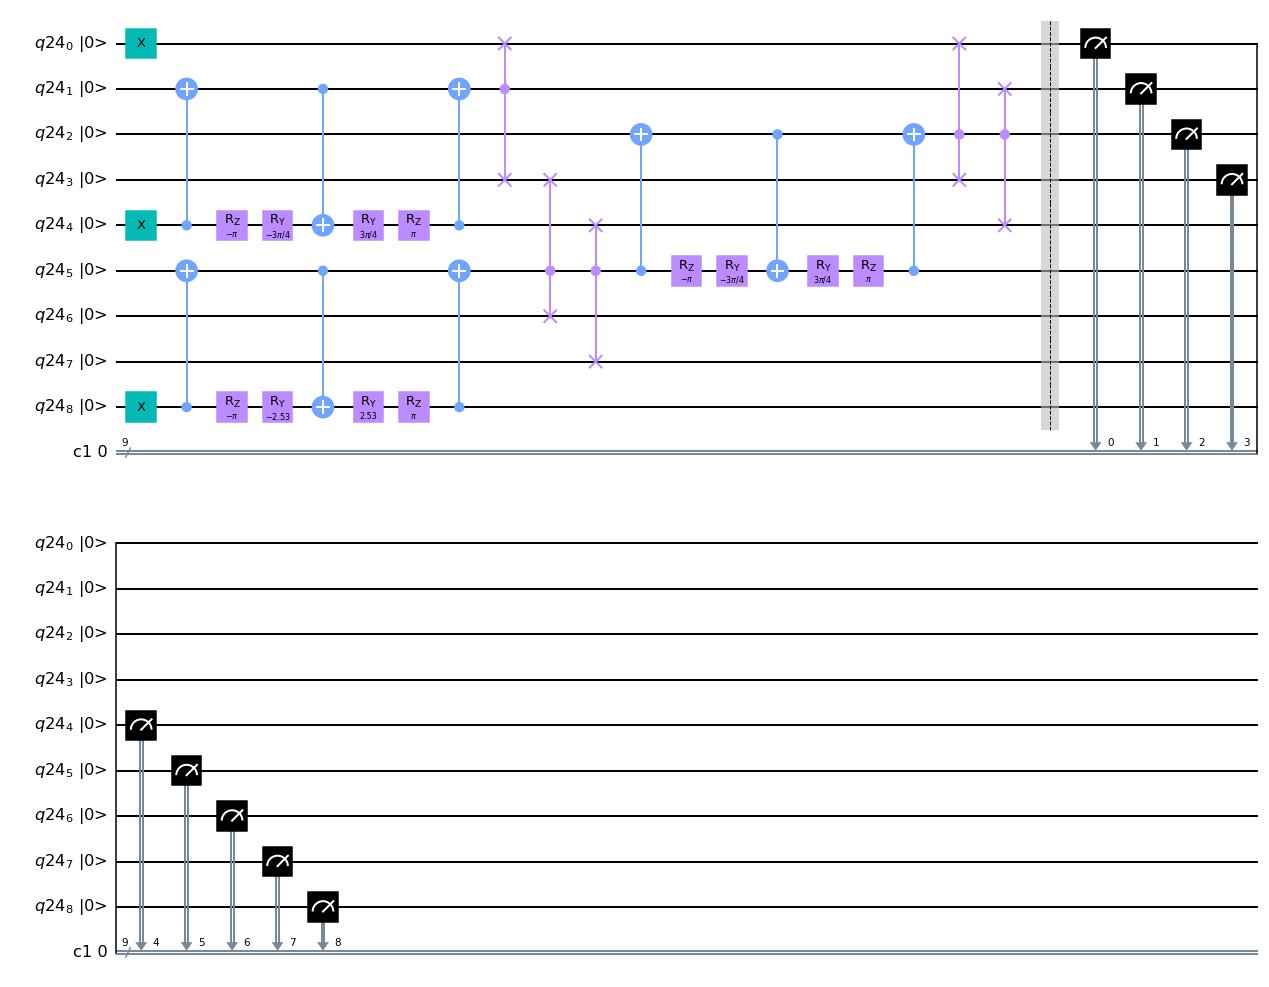

In [10]:
chain.draw(output='mpl', initial_state=True)

### Executing the circuit on the local qasm simulator

In [11]:
from qiskit import Aer

simulator = Aer.get_backend('qasm_simulator')

In [12]:
# We've set the number of shots (repeats) of the circuit
# to be 1024, which is the default value
job_sim = execute(chain, backend=simulator, shots=10240)

In [13]:
# Grab the results from the job
result_sim = job_sim.result()

In [14]:
counts_sim = result_sim.get_counts(chain)
print(counts_sim)

{'010001100': 1749, '001010100': 1647, '001100010': 1792, '100001010': 1668, '010100001': 1693, '100010001': 1691}


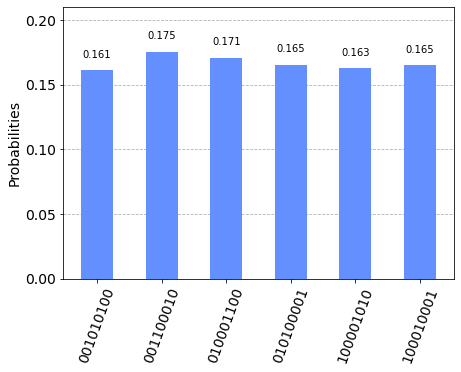

In [15]:
# Plot a histogram of the results
from qiskit.visualization import plot_histogram
plot_histogram(counts_sim)

# For arbitrary M

In [76]:
def index(subregister, qubit):
    return subregister*M+qubit

def angle(k):
    return acos(1/sqrt(k+2))

def ASWAP(circuit, k, target1, target2):
    circuit.cx(q[target2],q[target1])
    circuit.rz(-pi,q[target2])
    circuit.ry(-2.53,q[target2])
    circuit.cx(q[target1],q[target2])
    circuit.ry(2.53,q[target2])
    circuit.rz(pi,q[target2])
    circuit.cx(q[target2],q[target1])
    
def ASWAP2(circuit, k, target1, target2):
    gate = [
        [1,      0,              0,        0],
        [0, 1/sqrt(k+2), sqrt((k+1)/(k+2)),0],
        [0, sqrt((k+1)/(k+2)),-1/sqrt(k+2),0],
        [0,     0,              0,        1]]
    circuit.unitary(gate,[target1, target2])
    

In [126]:
M = 4

# create 3 quantum registers, one for each qubit
q=QuantumRegister(M**2)

# create 3 corresponding classical registers (needed for storing measurement results)
c=ClassicalRegister(M**2)

# create a quantum circuit with these registers
chain2 = QuantumCircuit(q,c)

k = 0

# NOT gate on the zeroeth qubit to obtain the 0 subregister.
chain2.x(q[k])

### ITERATION k=0 ###
for k in range(0, M-1):

    # NOT gate on the k+1 qubit of the k+1 subregister
    chain2.x(q[index(k+1,k+1)])

    # partial swap loop

    for i in range(0, k+1):
        # Construct ASWAP gates
        ASWAP2(chain2, k-i, index(k-i,k+1),index(k+1-i,k+1))

        # cSWAPs (controlled-SWAP gate); control = q[1], target=(q[0], q[3])
        # chain.cswap(q[1],q[0],q[3])

        # Iterate from: control at subregister k, qubit k+1 ---> control = q[index(k,k+1)]
        #                                             targets: (q[index(k,l)], q[index(k+1,l)]) with l =0 to l = k-1

        for l in range(0, k+1):
            chain2.cswap(q[index(k-i,k+1)], q[index(k-i,l)], q[index(k+1-i,l)])
            #chain2.cp(bethePhase,q[index(k-i,l)], q[index(k-i,k+1)])

#chain2.barrier()

# measurement gates
chain2.measure(q, c)

In [127]:
#chain2.basis = chain2.decompose()

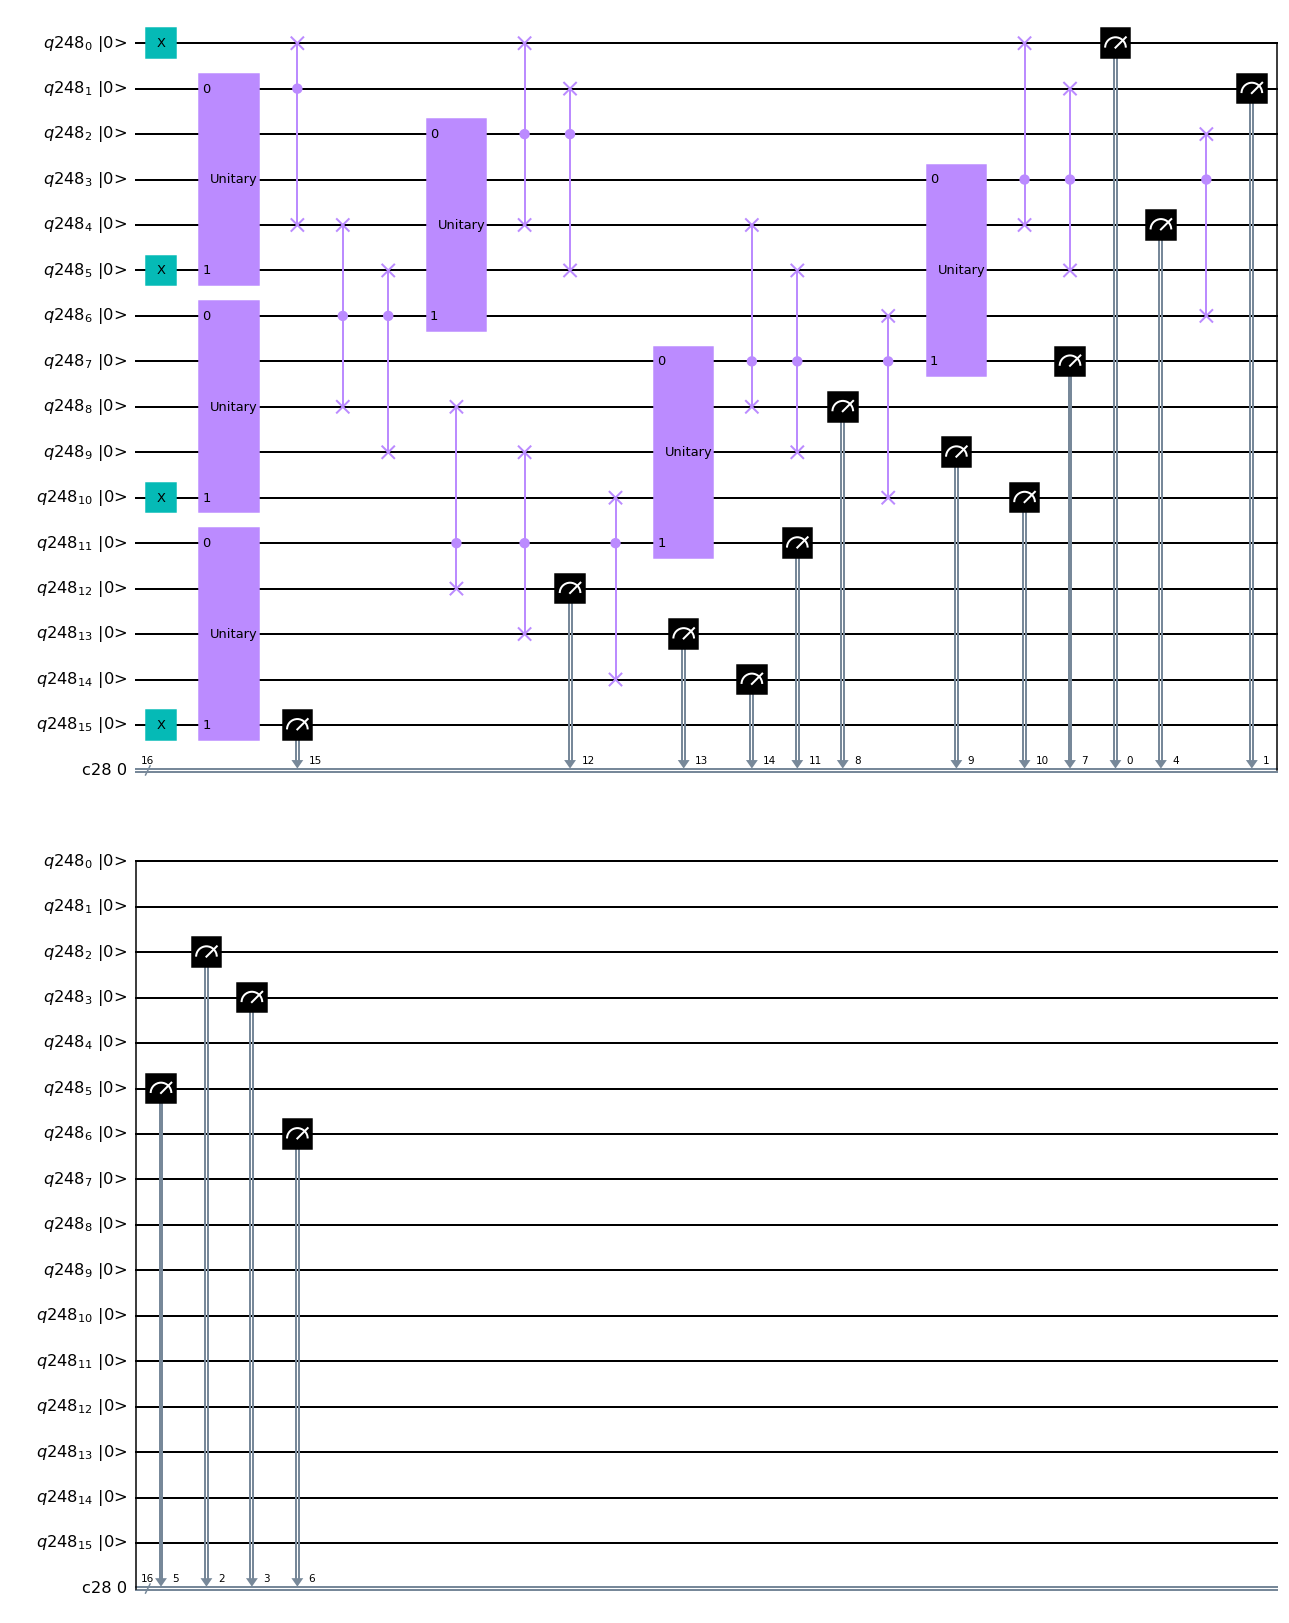

In [128]:
chain2.draw(output='mpl', initial_state=True)

In [129]:
from qiskit import Aer

simulator = Aer.get_backend('qasm_simulator')

In [130]:
# We've set the number of shots (repeats) of the circuit
# to be 1024, which is the default value
job_sim = execute(chain2, backend=simulator, shots=102400)

In [131]:
# Grab the results from the job
result_sim = job_sim.result()

In [132]:
counts_sim = result_sim.get_counts(chain2)
print(counts_sim)

{'1000000100100100': 4136, '0100001010000001': 4235, '1000010000100001': 4403, '0010000110000100': 4324, '0100100000100001': 4186, '1000001001000001': 4162, '0010000101001000': 4193, '1000000101000010': 4159, '0010010010000001': 4370, '1000010000010010': 4378, '0001010000101000': 4257, '0100100000010010': 4221, '0001001010000100': 4198, '0001100001000010': 4267, '0100000110000010': 4198, '0100000100101000': 4365, '0001001001001000': 4306, '0001010010000010': 4260, '0010010000011000': 4312, '0100001000011000': 4222, '1000001000010100': 4324, '0001100000100100': 4363, '0010100000010100': 4314, '0010100001000001': 4247}


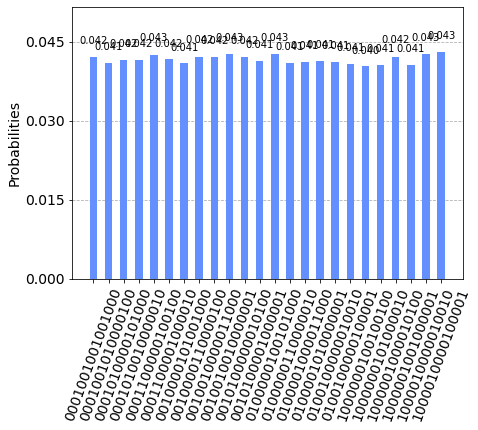

In [133]:
# Plot a histogram of the results
from qiskit.visualization import plot_histogram
plot_histogram(counts_sim)